In [94]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os, json
from pathlib import Path
import datetime
from datetime import datetime as dt



warnings.filterwarnings("ignore")

import os
output_folder = "data/daily"
os.makedirs(output_folder, exist_ok=True)

# URLs
URL_GAINERS = "https://query1.finance.yahoo.com/v1/finance/screener/predefined/saved?scrIds=day_gainers&count=250"
URL_ACTIVE = "https://query1.finance.yahoo.com/v1/finance/screener/predefined/saved?scrIds=most_actives&count=250"
URL_TRENDING = "https://query1.finance.yahoo.com/v1/finance/screener/predefined/saved?scrIds=trending_tickers&count=250"

def fetch_screener(scrId, count=250): 
    url = f"https://query1.finance.yahoo.com/v1/finance/screener/predefined/saved?scrIds={scrId}&count={count}"
    try:
        r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
        data = r.json()["finance"]["result"][0]["quotes"]
        return pd.DataFrame(data)
    except Exception as e:
        print(f"Error loading screener {scrId}: {e}")

def fetch_trending():
    url = "https://query1.finance.yahoo.com/v1/finance/trending/US"
    try:
        r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
        data = r.json()["finance"]["result"][0]["quotes"]
        return pd.DataFrame(data)
    except Exception as e:
        print(f"Error loading trending {e}")

In [95]:
import re

def filter_equities(df):
    eq = []
    for s in df["symbol"]:
        if re.fullmatch(r"[A-Za-z][A-Za-z0-9\.-]{0,9}", s):
            eq.append(s)
    return pd.DataFrame({"symbol": eq})

print("Downloading Yahoo lists...")

df_gainers = fetch_screener("day_gainers")
df_active  = fetch_screener("most_actives")
df_trending_raw = fetch_trending()
df_trending = filter_equities(df_trending_raw)


print("Gainers:", len(df_gainers))
print("Most Active:", len(df_active))
print("Trending:", len(df_trending))

combined = pd.concat([df_gainers, df_active, df_trending], ignore_index=True)
combined.drop_duplicates(subset="symbol", inplace=True)

print("Total unique hot symbols:", len(combined))


Gainers: 106
Most Active: 250
Trending: 20
Total unique hot symbols: 335


In [96]:
def fix_num(x):
    """
    Convert Yahoo formatted numbers:
    '1.2M', '330K', '2.3B' → float
    """
    if x is None:
        return np.nan
    if isinstance(x, (int, float)):
        return float(x)

    x = str(x).replace(",", "")

    try:
        if x.endswith("M"):
            return float(x[:-1]) * 1e6
        if x.endswith("B"):
            return float(x[:-1]) * 1e9
        if x.endswith("K"):
            return float(x[:-1]) * 1e3
        return float(x)
    except:
        return np.nan

numeric_cols = [
    "regularMarketPrice",
    "regularMarketChangePercent",
    "regularMarketChange",
    "regularMarketVolume",
    "averageDailyVolume3Month",
    "marketCap"
]

for col in numeric_cols:
    if col in combined.columns:
        combined[col] = combined[col].apply(fix_num)
    
df = combined.copy()

# Volume Spike Score
df["VolumeSpike"] = df["regularMarketVolume"] / df["averageDailyVolume3Month"]
df["VolumeScore"] = df["VolumeSpike"].rank(pct=True)

# Momentum Score (based on daily % change)
df["MomentumScore"] = df["regularMarketChangePercent"].rank(pct=True)

# Volatility Score (higher movement = more hot)
df["VolatilityScore"] = df["regularMarketChange"].abs().rank(pct=True)

# Trend Score (proxy: price vs avg volume)
df["TrendScore"] = (df["regularMarketPrice"] / (df["averageDailyVolume3Month"] + 1)).rank(pct=True)

# Final score
df["HotScore"] = (
    0.35 * df["MomentumScore"] +
    0.35 * df["VolumeScore"] +
    0.20 * df["VolatilityScore"] +
    0.10 * df["TrendScore"]
)

df.sort_values("HotScore", ascending=False, inplace=True)

# Keep relevant columns
output_df = df[[
    "symbol",
    "regularMarketPrice",
    "regularMarketChangePercent",
    "regularMarketVolume",
    "averageDailyVolume3Month",
    "marketCap",
    "VolumeSpike",
    "MomentumScore",
    "VolumeScore",
    "VolatilityScore",
    "TrendScore",
    "HotScore"
]]

top50 = output_df.head(50)

timestamp = dt.now().strftime("%Y%m%d%H%M%S") 
file_path = os.path.join(output_folder, f"hot_stocks_{timestamp}.csv")
top50.to_csv(file_path, index=False)

print("\n🔥 Saved TOP 50 hot stocks to:", file_path)
top50


🔥 Saved TOP 50 hot stocks to: data/daily\hot_stocks_20251119215553.csv


,symbol,regularMarketPrice,regularMarketChangePercent,regularMarketVolume,averageDailyVolume3Month,marketCap,VolumeSpike,MomentumScore,VolumeScore,VolatilityScore,TrendScore,HotScore
7,DY,326.1250,10.102966,925779.0,376539.0,9.442656e+09,2.458654,0.978462,0.947692,0.987692,0.984615,0.970154
1,EXAS,86.1600,23.661171,18033597.0,2618087.0,1.632485e+10,6.888082,0.996923,0.990769,0.956923,0.815385,0.968615
4,TMDX,133.3500,13.924057,1496959.0,955337.0,4.557146e+09,1.566943,0.987692,0.867692,0.953846,0.932308,0.933385
3,AMTM,25.6850,17.875164,9007179.0,1505262.0,6.249896e+09,5.983795,0.993846,0.987692,0.800000,0.732308,0.926769
10,LITE,270.9200,9.493603,5804630.0,3925573.0,1.921164e+10,1.478671,0.972308,0.861538,0.981538,0.880000,0.926154
8,MOD,143.5150,9.914216,1315769.0,900604.0,7.555859e+09,1.460985,0.975385,0.855385,0.938462,0.947692,0.923231
11,HNGE,44.2299,8.887005,5140027.0,1318098.0,3.481752e+09,3.899579,0.966154,0.975385,0.790769,0.818462,0.919538
50,IDXX,700.9300,4.583633,777213.0,459410.0,5.607769e+10,1.691763,0.858462,0.889231,0.990769,0.996923,0.909538
2,PACS,16.9250,17.290360,4479288.0,1154657.0,2.626379e+09,3.879323,0.990769,0.972308,0.723077,0.713846,0.903077
14,GEV,598.2200,7.800981,3421986.0,2946879.0,1.628498e+11,1.161224,0.953846,0.769231,0.993846,0.956923,0.897538


In [97]:
top50['symbol']

7         DY
1       EXAS
4       TMDX
3       AMTM
10      LITE
8        MOD
11      HNGE
50      IDXX
2       PACS
14       GEV
20       SQM
6       BRBR
17       XYZ
18      GPCR
60       LOW
0       NUVB
37       VIK
23       CEG
36        GH
26       EAT
38      FROG
9         MP
47      PODD
62       GFF
29      VEON
59        LB
12      KYIV
21      SITM
35      GKOS
27      CAMT
5       ADPT
15       LEU
25      FTAI
42       CLS
88     GOOGL
91      GOOG
13      GRAL
135      LNW
51      VSEC
67      IESC
30      COGT
16      UPWK
34      NBIS
22         U
40        AS
54      SHOP
61      LMND
78       CCJ
31      AMBA
39       LTM
Name: symbol, dtype: object

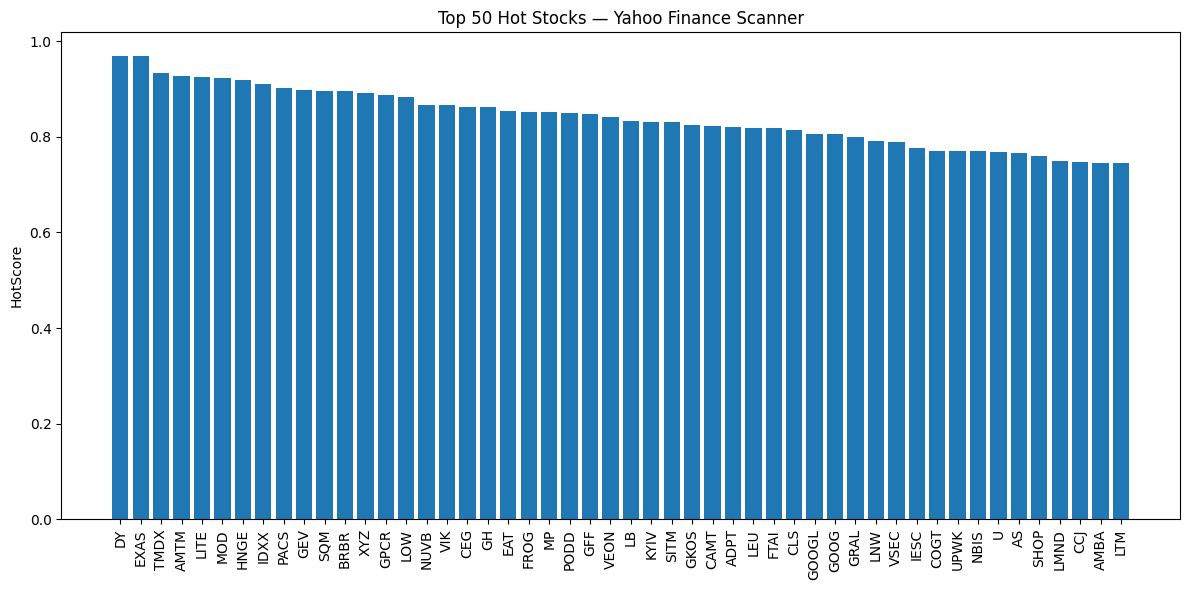

In [98]:
plt.figure(figsize=(12, 6))
plt.bar(top50["symbol"], top50["HotScore"])
plt.xticks(rotation=90)
plt.title("Top 50 Hot Stocks — Yahoo Finance Scanner")
plt.ylabel("HotScore")
plt.tight_layout()
plt.show()

In [ ]:

try:
    top50  # DataFrame with columns including symbol, HotScore, regularMarketPrice, regularMarketChangePercent, regularMarketVolume, VolumeSpike
except NameError:
    raise RuntimeError("Expected DataFrame 'top50' not found. Rename your top50 var or adapt this block.")

# configuration
today = datetime.date.today()
date_str = today.strftime("%Y%m%d") 
timestamp = dt.now().strftime("%Y%m%d%H%M%S")

OUT_DAILY = Path("output/daily")
DATA_DAILY = Path("data/daily")
ML_FOLDER = Path("ml")

for p in (OUT_DAILY, DATA_DAILY, ML_FOLDER):
    p.mkdir(parents=True, exist_ok=True)

# 1) Save top50 CSV
top50_file = DATA_DAILY / f"hot_stocks_{timestamp}.csv"   # keep full timestamp for uniqueness
top50.to_csv(top50_file, index=False)
print("Saved:", top50_file)


# 2) Heatmap of HotScore (symbols x 1 day) -> very small heatmap but useful in dashboard
# We'll produce a horizontal heatmap (symbols on y)
heatmap_file = OUT_DAILY / f"heatmap_hotscore_{date_str}.png"
plt.figure(figsize=(10, max(4, 0.18*len(top50))))
# prepare matrix: each symbol a single value -> use imshow
vals = top50["HotScore"].values.reshape((-1,1))
plt.imshow(vals, aspect='auto', cmap='YlOrRd')
plt.yticks(range(len(top50)), top50["symbol"])
plt.xticks([])
plt.colorbar(label='HotScore')
plt.title(f"HotScore - Top50 - {date_str}")
plt.tight_layout()
plt.savefig(heatmap_file, dpi=200)
plt.close()
print("Saved:", heatmap_file)

# 3) Volume spike bar chart (top50)
vol_file = OUT_DAILY / f"volume_spike_{date_str}.png"
plt.figure(figsize=(12,4))
plt.bar(top50["symbol"], top50["VolumeSpike"])
plt.xticks(rotation=90)
plt.title(f"Volume Spike — Top50 — {date_str}")
plt.tight_layout()
plt.savefig(vol_file, dpi=200)
plt.close()
print("Saved:", vol_file)

# 4) Momentum bar chart (daily percent change)
mom_file = OUT_DAILY / f"momentum_percent_{date_str}.png"
plt.figure(figsize=(12,4))
plt.bar(top50["symbol"], top50["regularMarketChangePercent"])
plt.xticks(rotation=90)
plt.title(f"Momentum (% change today) — Top50 — {date_str}")
plt.tight_layout()
plt.savefig(mom_file, dpi=200)
plt.close()
print("Saved:", mom_file)

# 5) Basic HTML report (table + embedded images) — lightweight single-file
html_file = OUT_DAILY / f"daily_report_{date_str}.html"
html_parts = []
html_parts.append(f"<h1>Daily Hot Stocks — {date_str}</h1>")
html_parts.append(f"<p>Generated at: {timestamp}</p>")
# table top10 in HTML
html_parts.append("<h2>Top 50 (summary)</h2>")
html_parts.append(top50.head(50).to_html(index=False, classes='table table-sm', border=0))

# embed images with relative paths (served from Firebase later)
html_parts.append("<h2>Heatmap</h2>")
html_parts.append(f'<img src="{heatmap_file.name}" alt="heatmap" style="max-width:100%;">')
html_parts.append("<h2>Volume Spike</h2>")
html_parts.append(f'<img src="{vol_file.name}" alt="volume" style="max-width:100%;">')
html_parts.append("<h2>Momentum %</h2>")
html_parts.append(f'<img src="{mom_file.name}" alt="momentum" style="max-width:100%;">')

with open(html_file, "w", encoding="utf-8") as fh:
    fh.write("<html><head><meta charset='utf-8'><title>Daily Hot Stocks</title></head><body>")
    fh.write("\n".join(html_parts))
    fh.write("</body></html>")

print("Saved:", html_file)

# 7) JSON metadata
meta = {
    "date": date_str,
    "timestamp": timestamp,
    "count_top50": len(top50),
    "top_symbols": top50["symbol"].tolist(),
    "files": {
        "daily_summary_csv": str(daily_summary_file),
        "daily_top50_csv": str(top50_file),
        "heatmap_png": str(heatmap_file),
        "volume_png": str(vol_file),
        "momentum_png": str(mom_file),
        "html_report": str(html_file)
    }
}
meta_file = DATA_DAILY / f"metadata_daily_{date_str}.json"
with open(meta_file, "w", encoding="utf-8") as fh:
    json.dump(meta, fh, indent=2)
print("Saved:", meta_file)

# 8) ML feature row (append or create)
# We'll extract simple features from the top50 for ML: symbol, price, HotScore, volume spike, momentum
ml_row = top50[["symbol","regularMarketPrice","HotScore","VolumeSpike","regularMarketChangePercent"]].copy()
ml_row["date"] = date_str
ml_path = ML_FOLDER / f"features_{date_str}.csv"
ml_row.to_csv(ml_path, index=False)
print("Saved:", ml_path)

print("\nDaily outputs completed. Files saved to 'output/daily' and 'data/daily'.")

Saved: data\daily\hot_stocks_20251119215553.csv
Saved: output\daily\daily_top50_20251119.csv
Saved: output\daily\heatmap_hotscore_20251119.png
Saved: output\daily\volume_spike_20251119.png
Saved: output\daily\momentum_percent_20251119.png
Saved: output\daily\daily_report_20251119.html
Saved: data\daily\metadata_daily_20251119.json
Saved: ml\features_20251119.csv

Daily outputs completed. Files saved to 'output/daily' and 'data/daily'.
